In [1]:
%pylab inline
import uuid
import base64
from six.moves import cPickle as pickle
import seaborn as sns
import pandas as pd
from matplotlib import patches as mpatches
sns.set_style('whitegrid')
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
results_data = pickle.load(open("./statuses.pickle", 'rb'))

results_df = pd.DataFrame(results_data['run_statuses'])
invoke_df = pd.DataFrame(results_data['invoke_statuses'])

In [3]:
results_df = pd.concat([results_df, invoke_df], axis=1)
Cols = list(results_df.columns)
for i,item in enumerate(results_df.columns):
    if item in results_df.columns[:i]: Cols[i] = "toDROP"
results_df.columns = Cols
results_df = results_df.drop("toDROP",1)

In [4]:
results_df.dtypes

call_id                       object
callgroup_id                  object
data_download_time           float64
data_key                      object
end_time                     float64
exception                     object
exec_time                    float64
executor_id                   object
func_download_time           float64
func_key                      object
function_exec_time           float64
host_submit_time             float64
ibm_cf_hostname               object
ibm_cf_python_version         object
ibm_cf_request_id             object
jobrunner_start              float64
output_key                    object
output_upload_time           float64
setup_time                   float64
start_time                   float64
status_key                    object
agg_data                        bool
cf_action_name                object
cf_activation_id              object
cf_endpoint                   object
cf_invoke_time               float64
cf_invoke_timestamp          float64
c

In [5]:
palette = sns.color_palette("deep", 6)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

ZeroDivisionError: integer division or modulo by zero

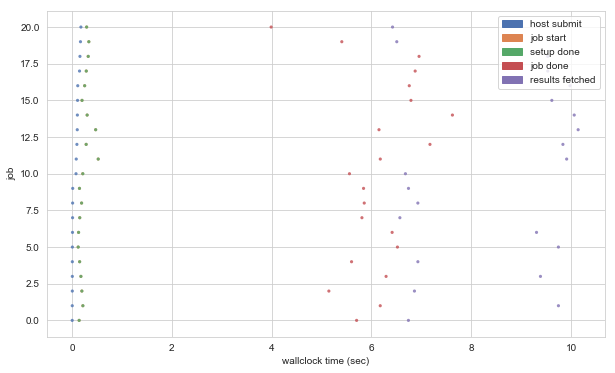

In [6]:

time_offset = np.min(results_df.host_submit_time)
fig = pylab.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
total_jobs = len(results_df)

y = np.arange(total_jobs)
point_size = 10

fields = [
          ('host submit', results_df.host_submit_time - time_offset), 
          ('job start', results_df.start_time - time_offset ), 
          ('setup done', results_df.start_time + results_df.setup_time - time_offset), 
          ('job done', results_df.end_time - time_offset), 
          ('results fetched', results_df.download_output_timestamp - time_offset)
         ]

patches = []
for f_i, (field_name, val) in enumerate(fields):
    
    ax.scatter(val, y, c=palette[f_i], edgecolor='none', s=point_size, alpha=0.8)
    patches.append(mpatches.Patch(color=palette[f_i], label=field_name))
ax.set_xlabel('wallclock time (sec)')
ax.set_ylabel('job')
#pylab.ylim(0, 10)


legend = pylab.legend(handles=patches, 
                      loc='upper right', frameon=True)
#pylab.title("Runtime for {} jobs of {:3.0f}M double ops (dgemm) each".format(total_jobs, JOB_GFLOPS))
legend.get_frame().set_facecolor('#FFFFFF')



plot_step = 100  #
plot_step = int(np.min([128, total_jobs/32]))
y_ticks = np.arange(total_jobs//plot_step + 2) * plot_step
ax.set_yticks(y_ticks)
ax.set_ylim(-0.02*total_jobs, total_jobs*1.05)

ax.set_xlim(-5, np.max(results_df.download_output_timestamp - time_offset)*1.05)
#ax.set_xlim(-0.02, np.max(8))

for y in y_ticks:
    ax.axhline(y, c='k', alpha=0.1, linewidth=1)
 
ax.grid(False)
fig.tight_layout()
#fig.savefig("timeline.png")

In [ ]:
runtime_bins = np.linspace(0, 300, 300)
def compute_times_rates(d):

    x = np.array(d)
    
    tzero = np.min(x[:, 0])
    start_time = x[:, 0] - tzero
    end_time = x[:, 1]  - tzero

    N = len(start_time)

    runtime_jobs_hist = np.zeros((N, len(runtime_bins)))

    for i in range(N):
        s = start_time[i]
        e = end_time[i]
        a, b = np.searchsorted(runtime_bins, [s, e])
        if b-a > 0:
            runtime_jobs_hist[i, a:b] = 1

    return {'start_time' : start_time,
            'end_time' : end_time,
            'runtime_jobs_hist' : runtime_jobs_hist}

In [ ]:
from matplotlib.collections import LineCollection
fig = pylab.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

time_rates =[(rs['start_time'], rs['end_time']) for rs in results_data['run_statuses']]

time_hist  = compute_times_rates(time_rates)

N = len(time_hist['start_time'])
line_segments = LineCollection([[[time_hist['start_time'][i], i], 
                                 [time_hist['end_time'][i], i]] for i in range(N)],
                               linestyles='solid', color='k', alpha=0.4, linewidth=0.2)

ax.add_collection(line_segments)



ax.plot(runtime_bins, time_hist['runtime_jobs_hist'].sum(axis=0), 
        label='active jobs total', 
        zorder=-1)

ax.set_xlim(0, 300)
ax.set_ylim(0, len(time_hist['start_time'])*1.05)
ax.set_xlabel("time (sec)")

ax.set_ylabel("IBM Cloud function execution")
ax.grid(False)
ax.legend(loc='upper right')
    
fig.tight_layout()